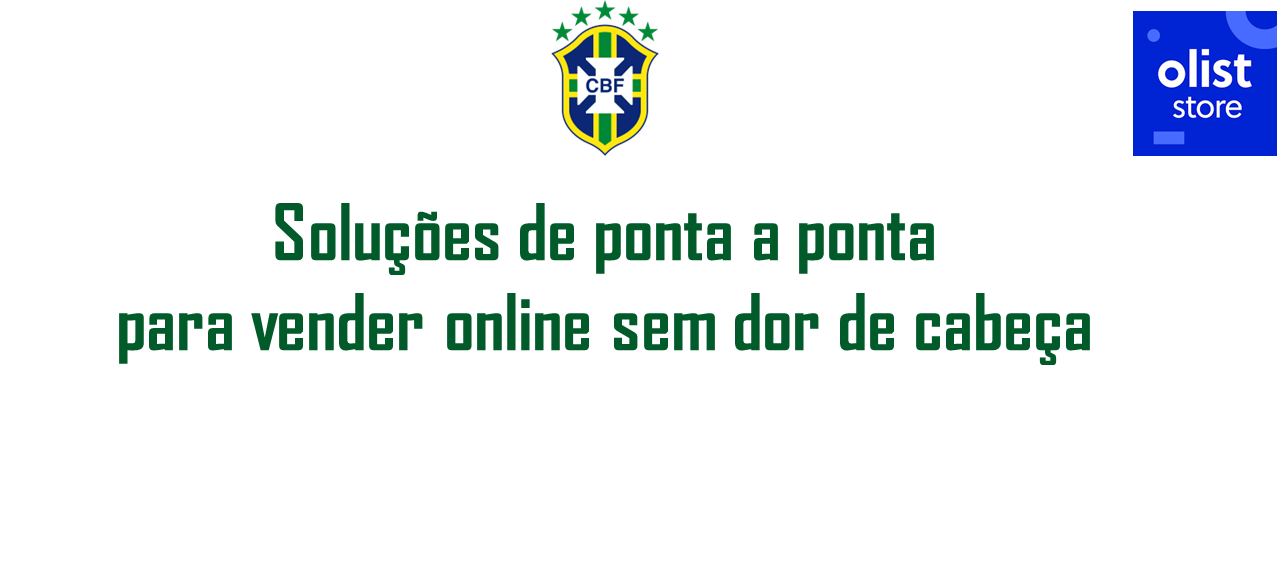

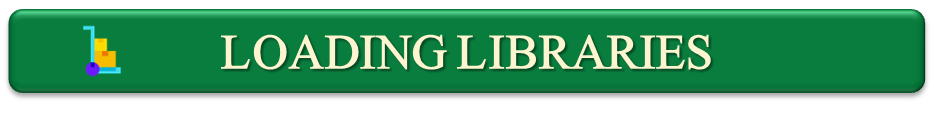

In [20]:
%load_ext pycodestyle_magic 
%pycodestyle_on 

In [21]:
import numpy as np
import pandas as pd

import matplotlib as plt
import matplotlib.pyplot as plt

import seaborn as sns

import missingno as msno

from scipy import stats
import scipy as sp

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from yellowbrick.features import PCA

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import PowerTransformer
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from IPython.display import display_html

from datetime import datetime, timedelta

In [22]:
def uni_analyse_quant(df):
    df = df.select_dtypes(include='number')
    for column_ in df.columns:
        data = df[column_]
        fig = plt.figure(figsize=(15, 10))
        grid = plt.GridSpec(2, 2, wspace=1, hspace=0.3)
        plt.subplot(grid[0, 0])
        sns.histplot(data, kde=True)
        plt.title('Distribution of ' + column_)
        plt.subplot(grid[0, 1])
        sns.boxplot(x=data)
        plt.title('Boxplot of ' + column_)
        plt.show()

In [23]:
def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table',
                                  'table style="display:inline"'), raw=True)

 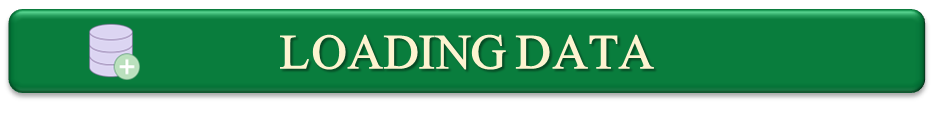

In [24]:
df = pd.read_csv('C:/Users/td/Documents/3. FORMATIONS/2 - OPENCLASSROOMS\
/Data Science/5. Projet 5/0. Data/customer_clusters.csv')

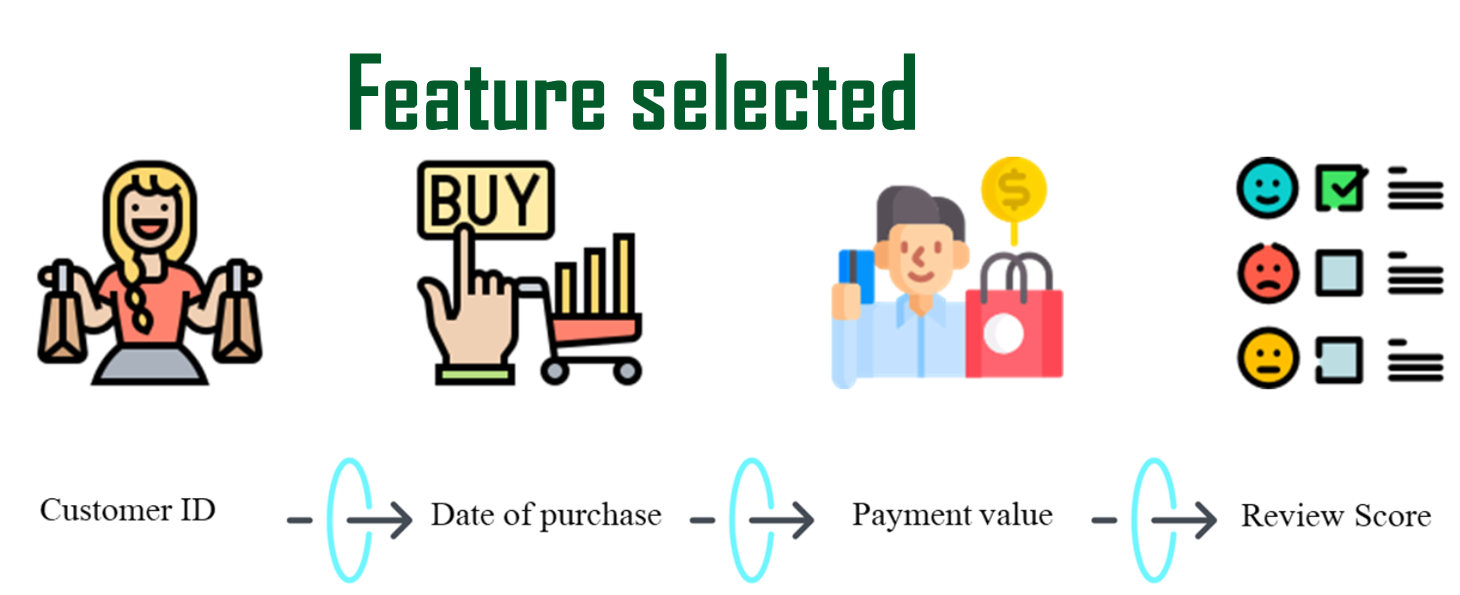

In [25]:
df.dtypes

customer_unique_id           object
order_id                     object
order_purchase_timestamp     object
review_score                float64
payment_value               float64
dtype: object

In [26]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

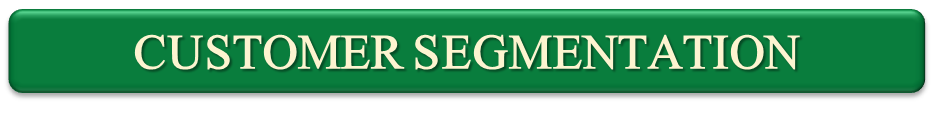

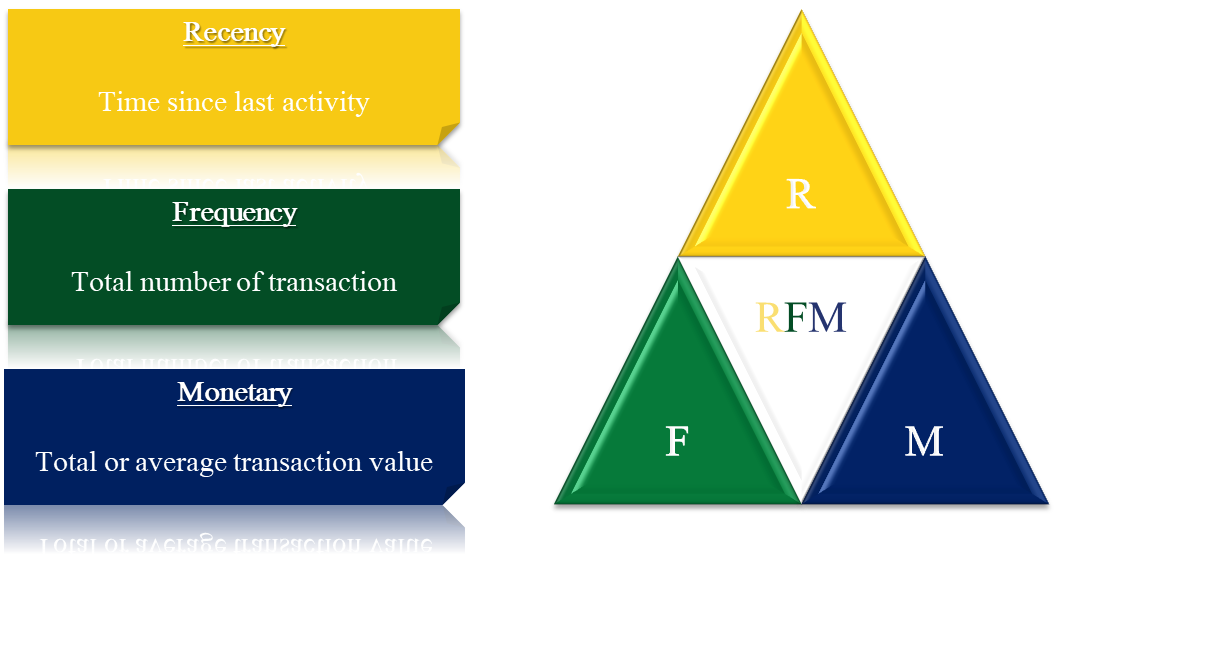

In [27]:
# Deadline : one day after last order

deadline = df['order_purchase_timestamp'].max()+timedelta(days=1)

In [28]:
df_rfm = (df
          .groupby(['customer_unique_id'])
          .agg({'order_purchase_timestamp': lambda x: (deadline-x.max()).days,
                'order_id': 'count',
                'payment_value': sum,
                'review_score': 'mean'})
          .rename(columns={
              'order_purchase_timestamp': 'Recency',
              'order_id': 'Frequency',
              'payment_value': 'Monetary'})
          .reset_index())

In [29]:
df_rfm.head(5)

,customer_unique_id,Recency,Frequency,Monetary,review_score
0,0000366f3b9a7992bf8c76cfdf3221e2,161,1,141.90,5.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,164,1,27.19,4.0
2,0000f46a3911fa3c0805444483337064,586,1,86.22,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,370,1,43.62,4.0
4,0004aac84e0df4da2b147fca70cf8255,337,1,196.89,5.0


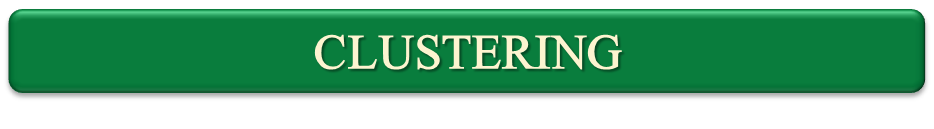

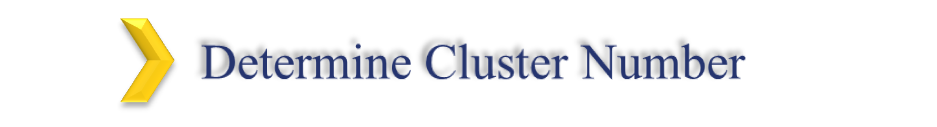

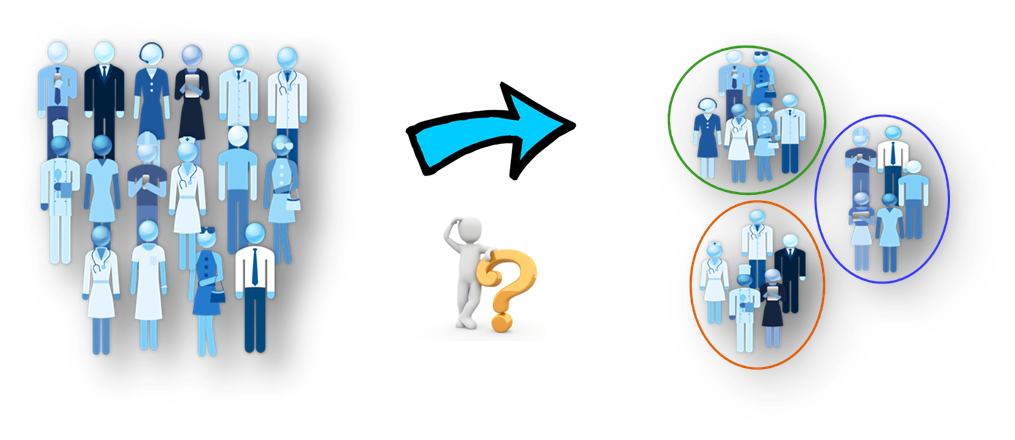

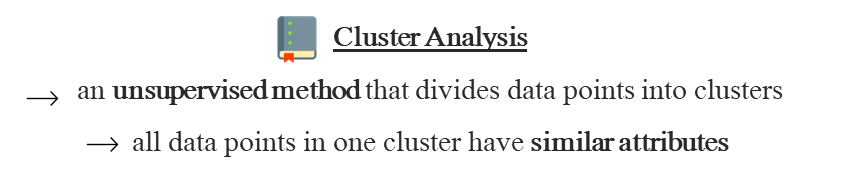

https://medium.com/mlearning-ai/elbow-method-vs-silhouette-co-efficient-in-determining-the-number-of-clusters-33baff2fbeee

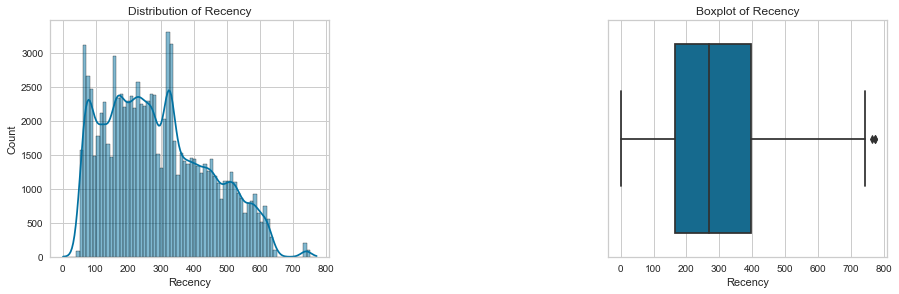

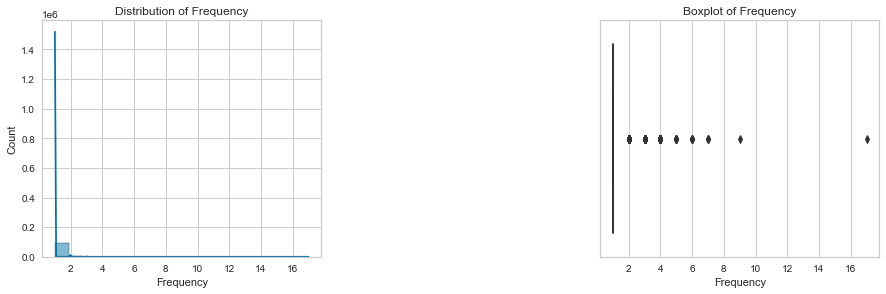

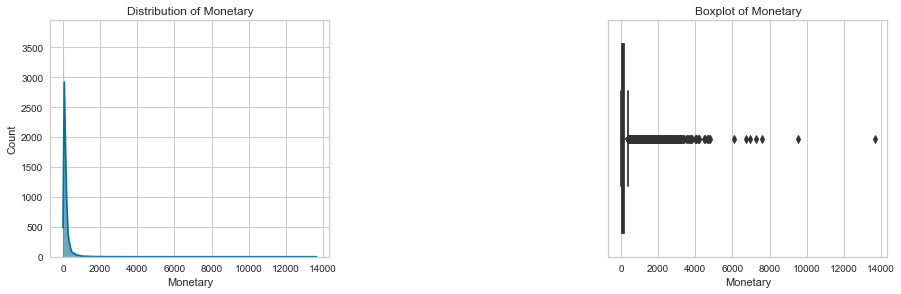

In [30]:
uni_analyse_quant(df_rfm.iloc[:, 1:-1])

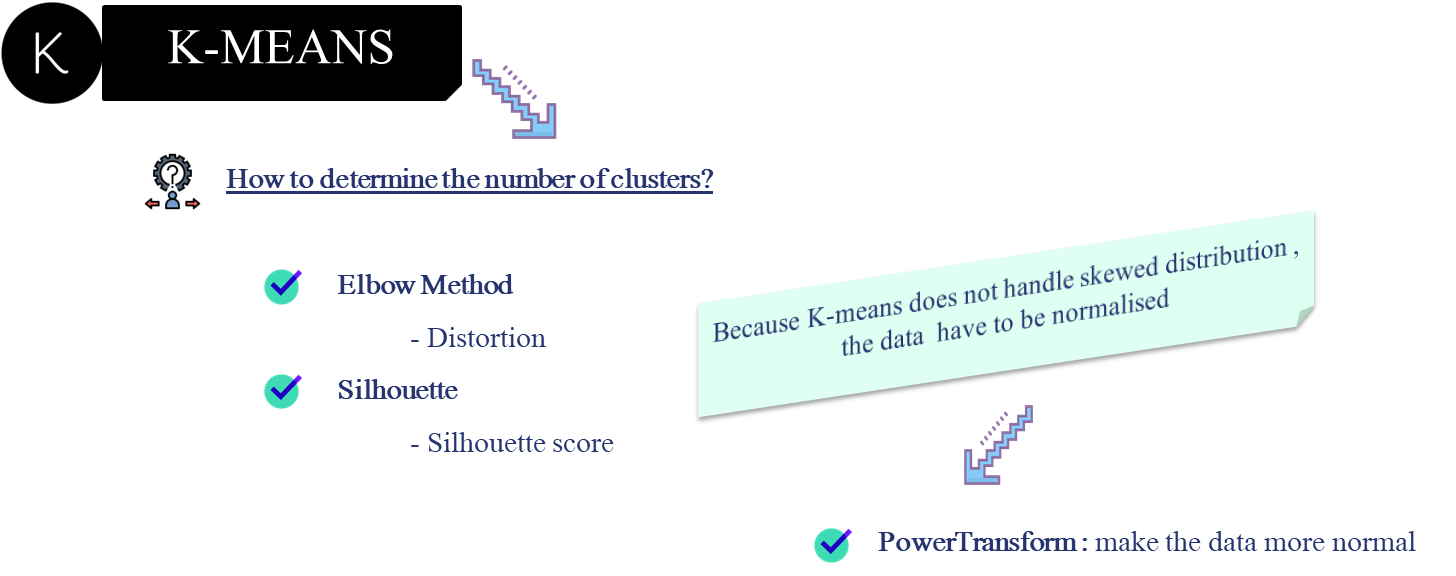

In [32]:
# feature names

feature_names = df_rfm.columns[1:]

In [33]:
# SMake data more normal

pt = PowerTransformer(method='yeo-johnson', standardize=True)

X_scaled = pt.fit_transform(df_rfm.iloc[:, 1:])

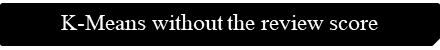

Elbow Method without the review score to determine the number of clusters to be formed:


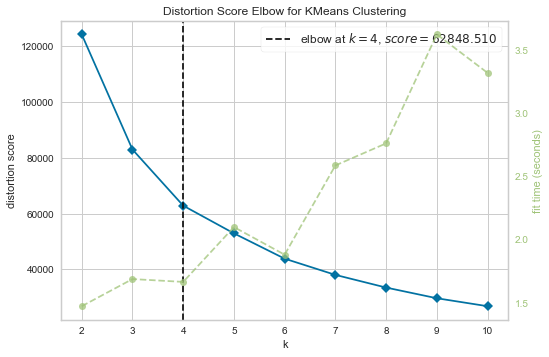

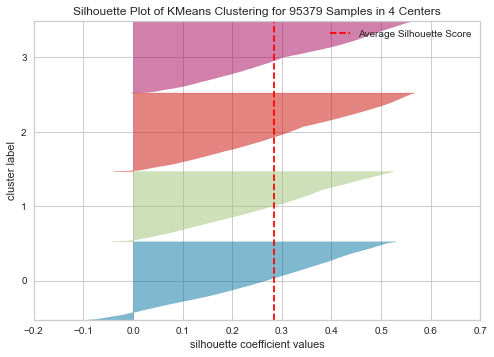

For n_clusters =  4  the average   silhoutte_score is : 0.15512620276326697


In [13]:
# Quick examination of elbow method to find numbers of clusters to make

# Without review score

print('Elbow Method without the review score \
to determine the number of clusters to be formed:')

model_out = KMeans()
Elbow_M = KElbowVisualizer(model_out, k=10)
Elbow_M.fit(X_scaled[:, :-1])
Elbow_M.show()

kmeans_n_cluster_out = Elbow_M.elbow_value_

visualizer = SilhouetteVisualizer(KMeans(kmeans_n_cluster_out),
                                  colors='yellowbrick')

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


silhouette_avg_out_kmeans = silhouette_score(X_scaled, model_out.labels_)
print("For n_clusters = ", kmeans_n_cluster_out,
      " the average   silhoutte_score is :",
      silhouette_avg_out_kmeans)

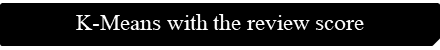

Elbow Method with the review score       to determine the number of clusters to be formed:


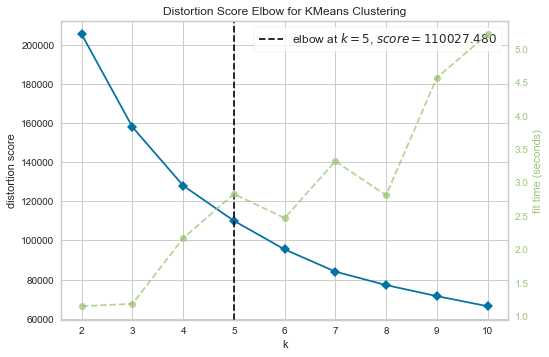

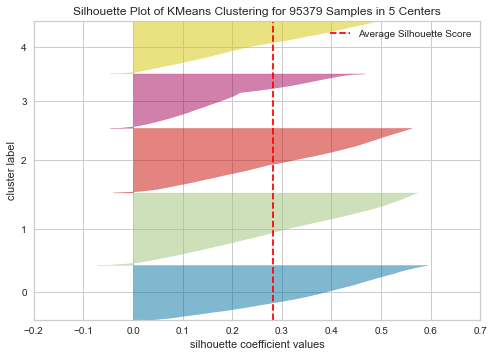

For n_clusters =  4  the average   silhoutte_score is : 0.27343314095984717


In [16]:
# Quick examination of elbow method to find numbers of clusters to make.

print('Elbow Method with the review score \
      to determine the number of clusters to be formed:')

model_with = KMeans()
Elbow_M = KElbowVisualizer(model_with, k=10)
Elbow_M.fit(X_scaled)
Elbow_M.show()

kmeans_n_cluster_with = Elbow_M.elbow_value_
visualizer = SilhouetteVisualizer(KMeans(kmeans_n_cluster_with),
                                  colors='yellowbrick')

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

silhouette_avg_with_kmeans = silhouette_score(X_scaled, model_with.labels_)
print("For n_clusters = ", kmeans_n_cluster_out,
      " the average   silhoutte_score is :",
      silhouette_avg_with_kmeans)

In [19]:
dict_data = {
    'Number_cluster': [kmeans_n_cluster_out, kmeans_n_cluster_with],
    'Silhouette Scoe': [silhouette_avg_out_kmeans, silhouette_avg_with_kmeans]
}

kmeans_score = pd.DataFrame(dict_data)

kmeans_score

,Number_cluster,Silhouette Scoe
0,4,0.155126
1,5,0.273433


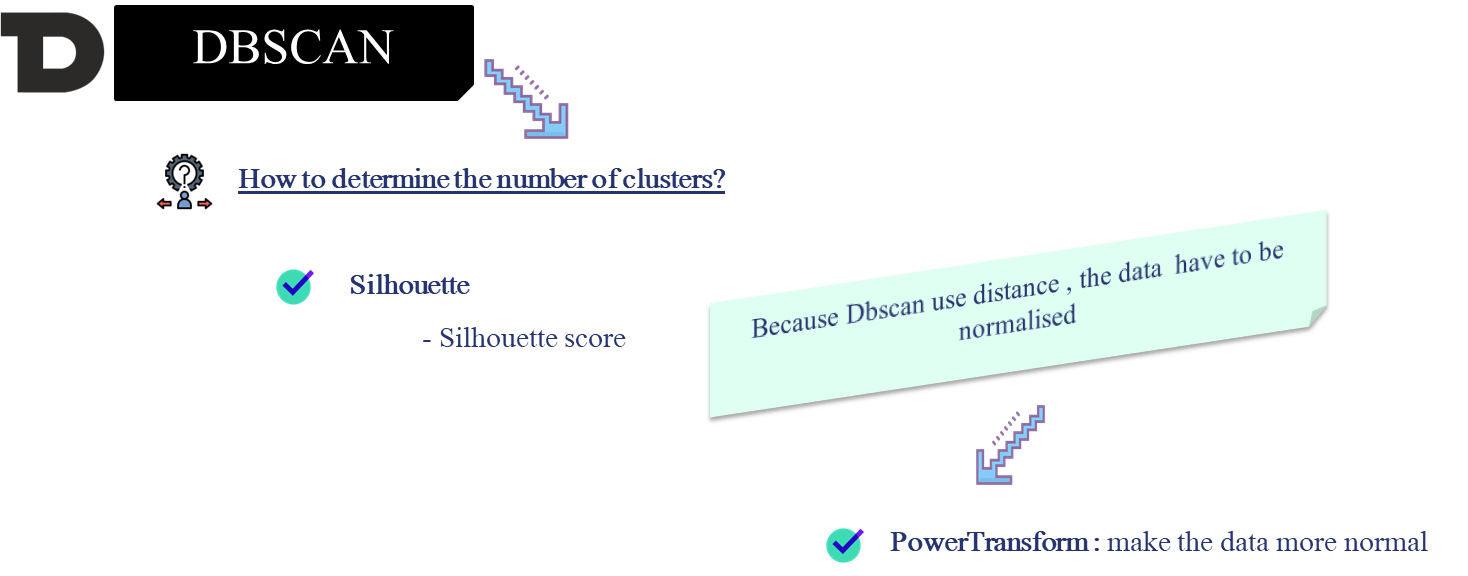

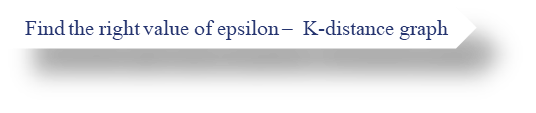

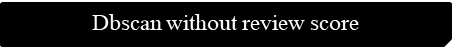

In [20]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled[:, :-1])
distances, indices = nbrs.kneighbors(X_scaled[:, :-1])

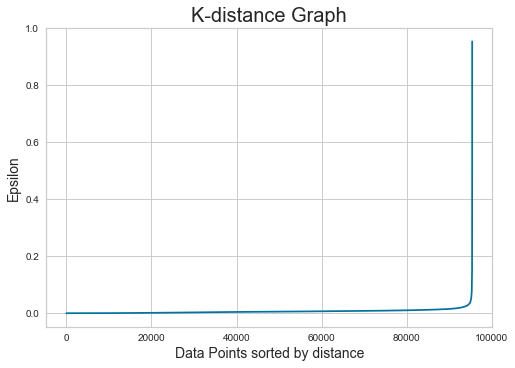

In [21]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('K-distance Graph', fontsize=20)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

In [22]:
list_eps = [0.05, 0.1, 0.2, 0.3, 0.4]

In [23]:
silh_score = []
nb_cluster = []
for i in list_eps:
    dbscan = DBSCAN(eps=i)
    dbscan.fit_predict(X_scaled[:, :-1])
    silh_score.append(metrics.silhouette_score
                      (X_scaled[:, :-1], dbscan.labels_))
    nb_cluster.append(len(set(dbscan.labels_))
                      - (1 if - 1 in dbscan.labels_ else 0))

In [24]:
dict_data = {
    'epsilon': list_eps,
    'Number_cluster': nb_cluster,
    'Silhouette Scoe': silh_score
}

dbscan_score_review_out = pd.DataFrame(dict_data)


dbscan_score_review_out

,epsilon,Number_cluster,Silhouette Scoe
0,0.05,70,-0.154393
1,0.10,6,0.085559
2,0.20,2,0.270505
3,0.30,2,0.278459
4,0.40,1,0.642100


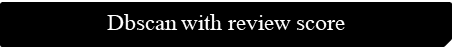

In [25]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

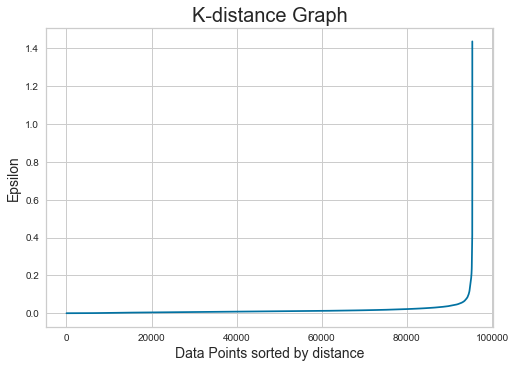

In [26]:
distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances)
plt.title('K-distance Graph', fontsize=20)
plt.xlabel('Data Points sorted by distance', fontsize=14)
plt.ylabel('Epsilon', fontsize=14)
plt.show()

In [27]:
list_eps = [0.05, 0.1, 0.2, 0.3, 0.4]

In [29]:
silh_score = []
nb_cluster = []
for i in list_eps:
    dbscan = DBSCAN(eps=i)
    dbscan.fit_predict(X_scaled)
    silh_score.append(metrics.silhouette_score(X_scaled, dbscan.labels_))
    nb_cluster.append(len(set(dbscan.labels_))
                      -(1 if - 1 in dbscan.labels_ else 0))

8:24: E225 missing whitespace around operator


In [30]:
dict_data = {
    'epsilon': list_eps,
    'Number_cluster': nb_cluster,
    'Silhouette Scoe': silh_score
}

dbscan_score_review_with = pd.DataFrame(dict_data)

dbscan_score_review_with

,epsilon,Number_cluster,Silhouette Scoe
0,0.05,662,-0.395929
1,0.10,109,-0.370231
2,0.20,20,-0.345905
3,0.30,9,-0.208242
4,0.40,1,0.423161


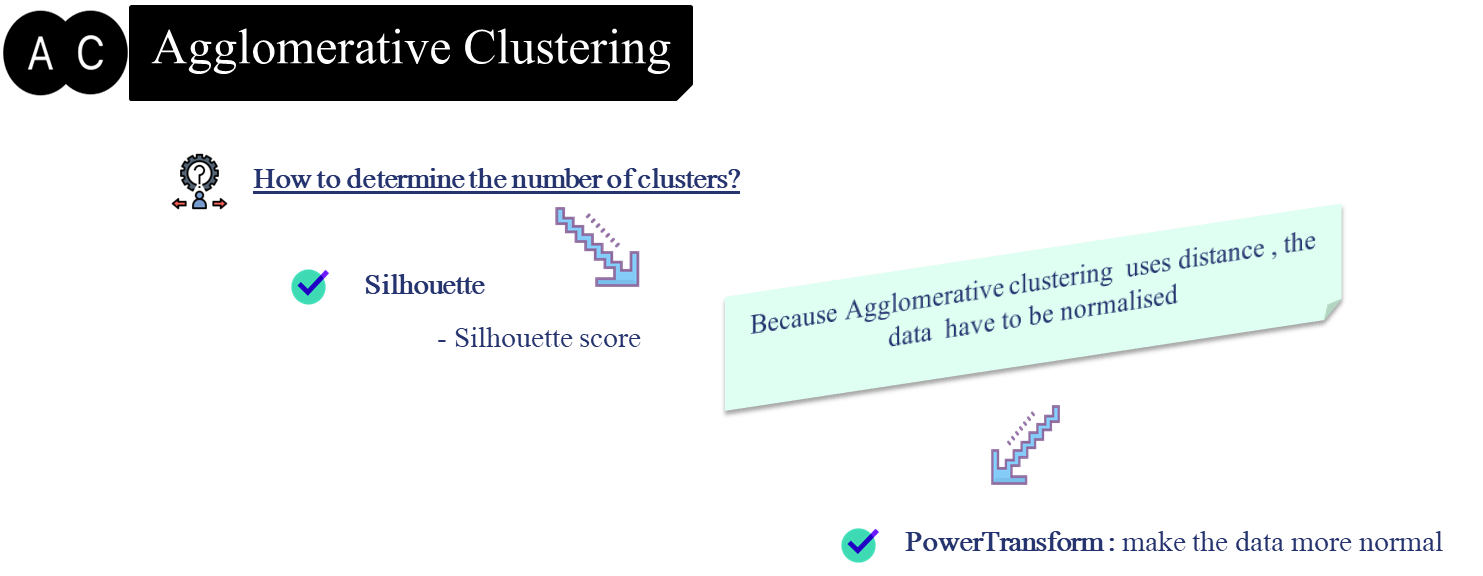

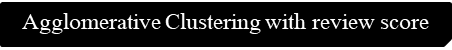

In [31]:
df_sample = df_rfm.sample(frac=0.3)
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled_sample = pt.fit_transform(df_sample.iloc[:, 1:])

In [32]:
list_n_cluster = [2, 3, 4, 5, 6]

sil_score_agg_clust = []

for n in list_n_cluster:
    cluster_agg = (AgglomerativeClustering(n_clusters=n)
                   .fit_predict(X_scaled_sample))
    (sil_score_agg_clust
     .append(metrics.silhouette_score(X_scaled_sample, cluster_agg)))

In [34]:
dict_score = {
    'number_cluster': list_n_cluster,
    'silhouette_score': sil_score_agg_clust
}

agg_clus_with = pd.DataFrame(dict_score)

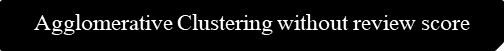

In [35]:
pt = PowerTransformer(method='yeo-johnson', standardize=True)
X_scaled_sample = pt.fit_transform(df_sample.iloc[:, 1:-1])

In [36]:
list_n_cluster = [2, 3, 4, 5, 6]

sil_score_agg_clust_out = []

for n in list_n_cluster:
    cluster_agg = (AgglomerativeClustering(n_clusters=n)
                   .fit_predict(X_scaled_sample))
    (sil_score_agg_clust_out
     .append(metrics.silhouette_score(X_scaled_sample, cluster_agg)))

In [37]:
dict_score = {
    'number_cluster': list_n_cluster,
    'silhouette_score': sil_score_agg_clust
}

agg_clust_out = pd.DataFrame(dict_score)

In [48]:
print('Kmeans score')
display_side_by_side(kmeans_score)

Kmeans score


,Number_cluster,Silhouette Scoe
0,4,0.155126
1,5,0.273433


In [49]:
print('Dbscan score')
display_side_by_side(dbscan_score_review_out, dbscan_score_review_with)

Dbscan score


,epsilon,Number_cluster,Silhouette Scoe
0,0.05,70,-0.154393
1,0.10,6,0.085559
2,0.20,2,0.270505
3,0.30,2,0.278459
4,0.40,1,0.642100
,epsilon,Number_cluster,Silhouette Scoe
0,0.05,662,-0.395929
1,0.10,109,-0.370231
2,0.20,20,-0.345905
3,0.30,9,-0.208242


In [50]:
print('Agg score')
display_side_by_side(agg_clus_with, agg_clust_out)

Agg score


,number_cluster,silhouette_score
0,2,0.295643
1,3,0.249796
2,4,0.223613
3,5,0.232597
4,6,0.252174
,number_cluster,silhouette_score
0,2,0.295643
1,3,0.249796
2,4,0.223613
3,5,0.232597


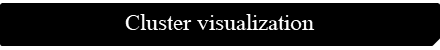

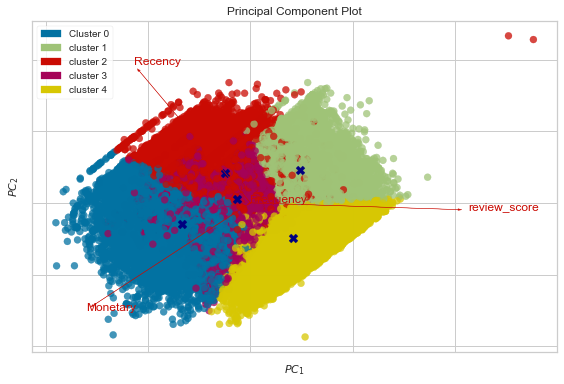

<AxesSubplot:title={'center':'Principal Component Plot'}, xlabel='$PC_1$', ylabel='$PC_2$'>

In [38]:
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_scaled)

# Specify the features of interest and the target

X, y = X_scaled, kmeans.labels_
classes = ['Cluster 0', 'cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']

# Visualisation en composante principales
visualizer = PCA(scale=False, features=feature_names,
                 proj_features=True, classes=classes, projection=2)

visualizer.fit_transform(X_scaled, y)

projected_centroide = (visualizer
                       .pca_transformer
                       .transform(kmeans.cluster_centers_))

# Visualisation des centroides
plt.scatter(projected_centroide[:, 0], projected_centroide[:, 1],
            marker="X", c='navy', s=80, label="centroids")

visualizer.show()

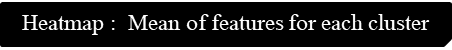

In [39]:
cluster_heatmap = (pd.concat([
    pd.DataFrame(X_scaled, columns=feature_names),
    pd.DataFrame(kmeans.labels_)], axis=1)
                   .rename(columns={
                       0: 'cluster'}))

<AxesSubplot:ylabel='cluster'>

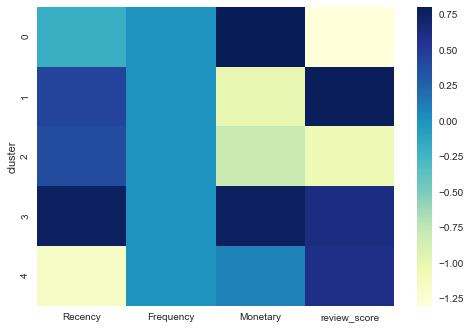

In [40]:
sns.heatmap((cluster_heatmap.groupby(by='cluster')
            .agg('mean')),
            cmap='YlGnBu')

In [41]:
cluster_df_rfm = (pd.concat([df_rfm, pd.DataFrame(kmeans.labels_)], axis=1)
                  .rename(columns={0: 'cluster'}))

(cluster_df_rfm
 .groupby(['cluster'])
 .agg({
     'Recency': ['mean', 'median'],
     'Frequency': ['mean', 'median'],
     'Monetary': ['mean', 'median'],
     'review_score': ['mean',  'median'],
     'customer_unique_id': 'count'})
 .rename(columns={'customer_unique_id': 'number of customer'})
 .sort_values([('number of customer',  'count')], ascending=False))

Recency        Frequency           Monetary         review_score  \
               mean median      mean median        mean  median         mean   
cluster                                                                        
4        125.227483    119  1.038447      1  153.092474  114.52     4.838089   
3        403.342110    395  1.055378      1  266.885984  177.31     4.864523   
1        349.667830    328  1.005663      1   55.334410   54.10     4.999414   
2        343.916691    327  1.007783      1   64.889693   62.14     2.876410   
0        252.003516    235  1.061200      1  281.185714  189.00     2.384757   

               number of customer  
        median              count  
cluster                            
4          5.0              23149  
3          5.0              20622  
1          5.0              17482  
2          3.0              17345  
0          3.0              16781

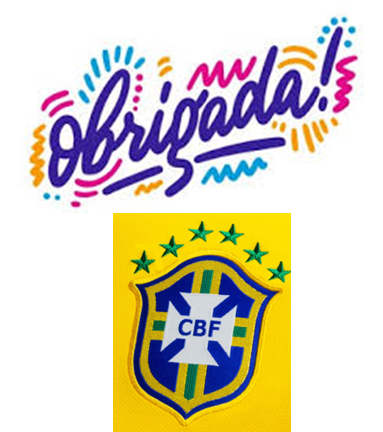